# CNN to classify e-, mu and gamma

This notebook has an example of a convolutional neural network used to classify the type of particle given an image of its Cherenkov ring in the Super-Kamiokande detector. Here is the performance analysis of the CNN. We will take 3 files classified as e-, mu and gamma and see if the classification has been well performed

In [2]:
# Import libraries

%matplotlib notebook
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import animation
from tqdm.notebook import tqdm
import math
import h5py
import altair as alt
from pathlib import Path
from math import sqrt
import tensorflow as tf

from tensorflow.keras import datasets, layers, models, optimizers
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, roc_curve, auc, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split

### Data upload

We check that the files are different from each other and upload them.

In [3]:
# In this case, the event are aroun 250 MeV

images_muon = np.load('/Users/macbookairdemilo/Desktop/simulations/mu_example.npy')
images_electron = np.load('/Users/macbookairdemilo/Desktop/simulations/e_example.npy')
images_gamma = np.load('/Users/macbookairdemilo/Desktop/simulations/gamma_example.npy')

We visualize to corroborate that they are different images.

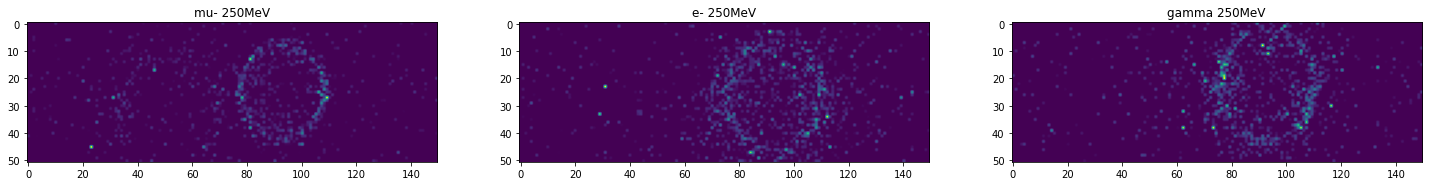

In [ ]:
fig=plt.figure(figsize=(25, 25))

fig.add_subplot(1, 3, 1).set_title('mu-')
plt.imshow(images_muon[0, :, :, 0])

fig.add_subplot(1, 3, 2).set_title('e-')
plt.imshow(images_electron[0, :, :, 0])

fig.add_subplot(1, 3, 3).set_title('gamma')
plt.imshow(images_gamma[0, :, :, 0])

plt.show()

### Train/test split

We will perform the analyzis for the e-/gamma classification

In [ ]:
X = np.concatenate([images_electron, images_gamma])
y = np.concatenate([np.ones(1000), np.zeros(1000)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

X train/test split (1400, 51, 150, 2) (600, 51, 150, 2)
y train/test split (1400,) (600,)


### Data normalization

Since the two channels have different scales, they are normalized separately.

In [ ]:
mean_0 = np.mean(X_train[:, :, :, 0].reshape(-1), keepdims=True)[0]
std_0 = np.std(X_train[:, :, :, 0].reshape(-1), keepdims=True)[0]

mean_1 = np.mean(X_train[:, :, :, 1].reshape(-1), keepdims=True)[0]
std_1 = np.std(X_train[:, :, :, 1].reshape(-1), keepdims=True)[0]

print('Channel 0 mean & std: ', mean_0, std_0)
print('Channel 1 mean & std: ', mean_1, std_1)

X_train[:, :, :, 0] = (X_train[:, :, :, 0]-mean_0)/std_0
X_train[:, :, :, 1] = (X_train[:, :, :, 0]-mean_1)/std_1

X_test[:, :, :, 0] = (X_test[:, :, :, 0]-mean_0)/std_0
X_test[:, :, :, 1] = (X_test[:, :, :, 1]-mean_1)/std_1

Channel 0 mean & std:  0.2420949704459311 0.8405114964319939
Channel 1 mean & std:  136.23762482951759 343.3868200945787


## Creation of the network

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(51, 150, 2)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(.3))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu' ))
model.add(layers.Dropout(.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 49, 148, 16)       304       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 74, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 74, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28416)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1818688   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [5]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=42, batch_size=30,
                    validation_data=(X_test, y_test))

### Visualization of results

In [ ]:
# Train vs test accuracy

plt.plot(history.history['train_accuracy'], label='train_accuracy')
plt.plot(history.history['test_accuracy'], label ='test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Classification e-/gamma')

In [ ]:
# Confusion matrix and additional metrics

y_pred = model.predict(X_test).round()

print(classification_report(y_test, y_pred))

ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_pred, labels=[1,0]), annot=True, cbar=False, fmt='g', cmap='mako')

ax.set_xlabel('Prediction')
ax.set_ylabel('Truth')
ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['e-', 'gamma'])
ax.yaxis.set_ticklabels(['e-', 'gamma']);

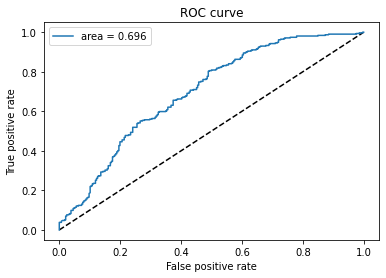

In [ ]:
# Plot the ROC curve

y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
area = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='area = {:.3f}'.format(area))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()